## Regression Model
---

Suppose we have data $(y_1,x_1),\dots,(y_n,x_n)$. Let $u_i$ denote the error term for the $i$-th pair $(y_i,x_i)$, $(i=1,\dots,n)$. We assume each $u_i$ independently follows the normal distribution with mean 0 and variance $\sigma^2$. Then the regression model is given by

$$
 y_i = \alpha + \beta x_i + u_i,\quad u_i \sim \mathrm{Normal}(0,\sigma^2).
$$

where $\alpha$, $\beta$ and $\sigma^2$ are unknown parameters.

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

PyMC (https://docs.pymc.io/index.html) is a Python package for Bayesian data analysis. Please read instructions at https://github.com/nakatsuma/probability_and_statistics before you install PyMC. It is a preferred practice to set up an independent environment for each project because it makes management of versions and dependencies much easier.


In [2]:
import pymc3 as pm

WARNING (theano.configdefaults): Only clang++ is supported. With g++, we end up with strange g++/OSX bugs.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


As a numerical illustration, we generate artificial data from a simple regression model.

$$
 y_i = 1 + 2 x_i + u_i,\quad u_i \sim \mathrm{Normal}(0, (0.7)^2).
$$

In this example, we generate $x_i$ from a uniform distribution over $[-\sqrt{3},\sqrt{3}]$ whose mean and variance are 0 and 1 respectively.

In [3]:
n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0 * x + u
X = np.stack((np.ones(n), x), axis=1)

The following cell plots the generated data.

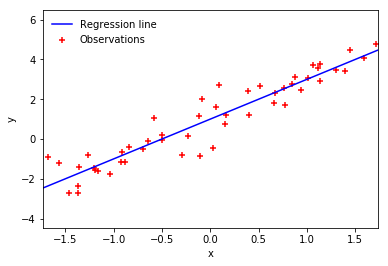

In [4]:
fig1 = plt.figure(num=1, facecolor='w')
plt.scatter(x, y, color='r', marker='+', label='Observations')
x_range = (-np.sqrt(3.0), np.sqrt(3.0))
y_range = (1.0 - 2.0*np.sqrt(3.0), 1.0 + 2.0*np.sqrt(3.0))
plt.plot(x_range, y_range, 'b-', label='Regression line')
plt.xlim(x_range)
plt.ylim(y_range[0] - 2.0, y_range[1] + 2.0)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left', frameon=False)
# plt.savefig('ms_fig_regression_scatter.png', dpi=300)
plt.show()

The prior distribution of $\alpha$, $\beta$ and $\sigma^2$ are

\begin{align*}
 \begin{bmatrix} \alpha \\ \beta \end{bmatrix}
 &\sim \mathrm{Normal}\left(
 \begin{bmatrix} \mu_{\alpha} \\ \mu_{\beta} \end{bmatrix},
 \begin{bmatrix} \omega_{\alpha}^2 & 0 \\ 0 & \omega_{\beta}^2 \end{bmatrix},
 \right), \\
 \sigma^2 &\sim \mathrm{Inv.Gamma}\left(\frac{\nu_0}{2},\frac{\lambda_0}{2}\right).
\end{align*}


In [5]:
mu_a = 0.0
mu_b = 0.0
omega_a = 10.0
omega_b = 10.0
nu0 = 0.02
lam0 = 0.02

In PyMC, the model is defined by `with` statement. A general syntax of `with` is as follows.

```Python
with model_object:
    model specifications
```

`model_object` is either given by a PyMC function `Model` as

```Python
 model_object = pm.Model()
```

or defined in the `with` statement as

```Python
with pm.Model() as model_object:
```

The following line specifies that `sigma2` follows the inverse gamma distribution, Inv.Gamma(0.5\*nu0, 0.5\*lam0).

```Python
sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
```

`'sigma2'` is the name of the variable.

These two lines specify that `a` and `b` follow the normal distributions, Normal(mu_a,omega_a\*\*2) and Normal(mu_b,omega_b\*\*2), respectively.

```Python
    a = pm.Normal('a', mu=mu_a, sd=omega_a)
    b = pm.Normal('b', mu=mu_b, sd=omega_b)
```

In the next line, we define the regression line `y_hat`.

```Python
    y_hat = a + b * x
```

Finally we specify the likelihood of the regression model.

```Python
    likelihood = pm.Normal('y', mu=y_hat, sd=pm.math.sqrt(sigma2), observed=y)
```

The option `observed` specifies the data vector.


In [6]:
regresssion_normal_invgamma = pm.Model()
with regresssion_normal_invgamma:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
    a = pm.Normal('a', mu=mu_a, sd=omega_a)
    b = pm.Normal('b', mu=mu_b, sd=omega_b)
    y_hat = a + b * x
    likelihood = pm.Normal('y', mu=y_hat, sd=pm.math.sqrt(sigma2), observed=y)

The following cell generates a Monte Carlo sample of parameters from the posterior distribution. 

+ `draws` - number of draws per chain you generate from the posterior distribution
+ `chains` - number of chains you generate (`chains` \* `draws` = sample size)
+ `tune` - number of initial draws for tuning parameters in the sampler
+ `random_seed` - seed of the pseudo-random number generator

In [7]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with regresssion_normal_invgamma:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b, a, sigma2]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:15<00:00, 1522.49draws/s]


A PyMC function `summary` computes the posterior statistics with the Monte Carlo sample.

In [8]:
display(pm.summary(trace))

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,1.001465,0.100506,0.000560,0.797586,1.193133,24634.054772,1.000007
b,2.011737,0.103273,0.000696,1.811869,2.213874,28937.622643,0.999913
sigma2,0.504274,0.108377,0.000712,0.320226,0.728028,21781.037882,1.000009


A PyMC function `traceplot` plots the Monte Carlo sample and draws the marginal posterior p.d.f. obtained with the kernel denisty estimation method.

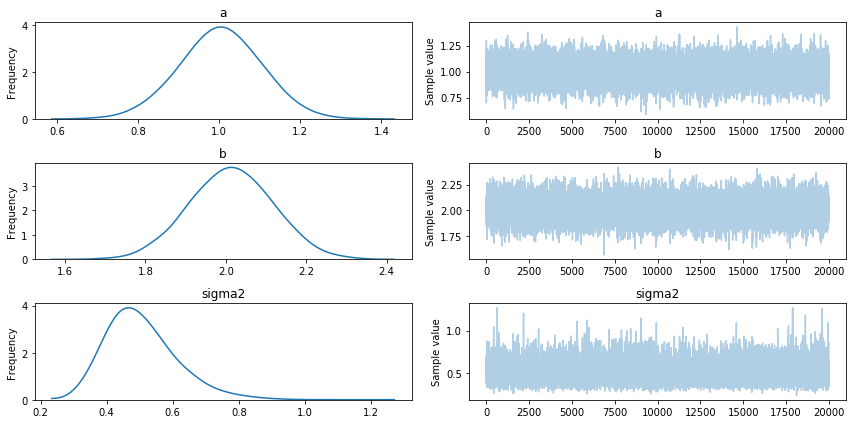

In [9]:
fig2, ax2 = plt.subplots(3, 2, num=2, facecolor='w', figsize=(12, 6))
h2 = pm.traceplot(trace, ax=ax2, combined=True)

A PyMC function `plot_posterior` plots the marginal posterior p.d.f with the point estimate and the HPDI.

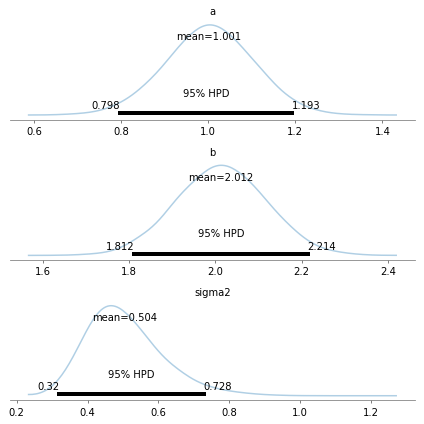

In [10]:
fig3, ax3 = plt.subplots(3, 1, num=3, facecolor='w', figsize=(6, 6))
h3 = pm.plot_posterior(trace, ax=ax3, kde_plot=True, point_estimate='mean')